In [1]:
# Loading of modules necessary for the demo
import os
import numpy as np
import pickle
import yaml

import gdown

from competence_estimation.scores  import create_score_function
from competence_estimation.metrics  import compute_metric

from competence_estimation.plots import plot_accuracy_coverage, plot_accuracy_curve

# Downloading and Loading some Results for the PACS data set
Data contains only the standard classifier (ERM) and the close-world scenario

In [2]:
url = 'https://drive.google.com/drive/folders/1u1i2pFj8Q0hbNxCM71tv8SwVFM8zOiNh?usp=sharing'
output_dir = './'

# Create folder if it does not exist
os.makedirs('results', exist_ok=True)

# download folder to directory
# Only download if not exists
#if not os.path.exists(output):
gdown.download_folder(url, output=output_dir, quiet=True, use_cookies=True)

['./results/results_scores.pickle', './results/true_false.pickle']

## Loading Results

In [5]:
with open('results/results_scores.pickle', 'rb') as handle:
    scores = pickle.load(handle)
    
with open('results/true_false.pickle', 'rb') as handle:
    true_false = pickle.load(handle)

# Plot of Existing Results
Here we provide computed scores for the ERM classifier and show some interesting results

## Showing Trade-Off Accuracy/Coverage

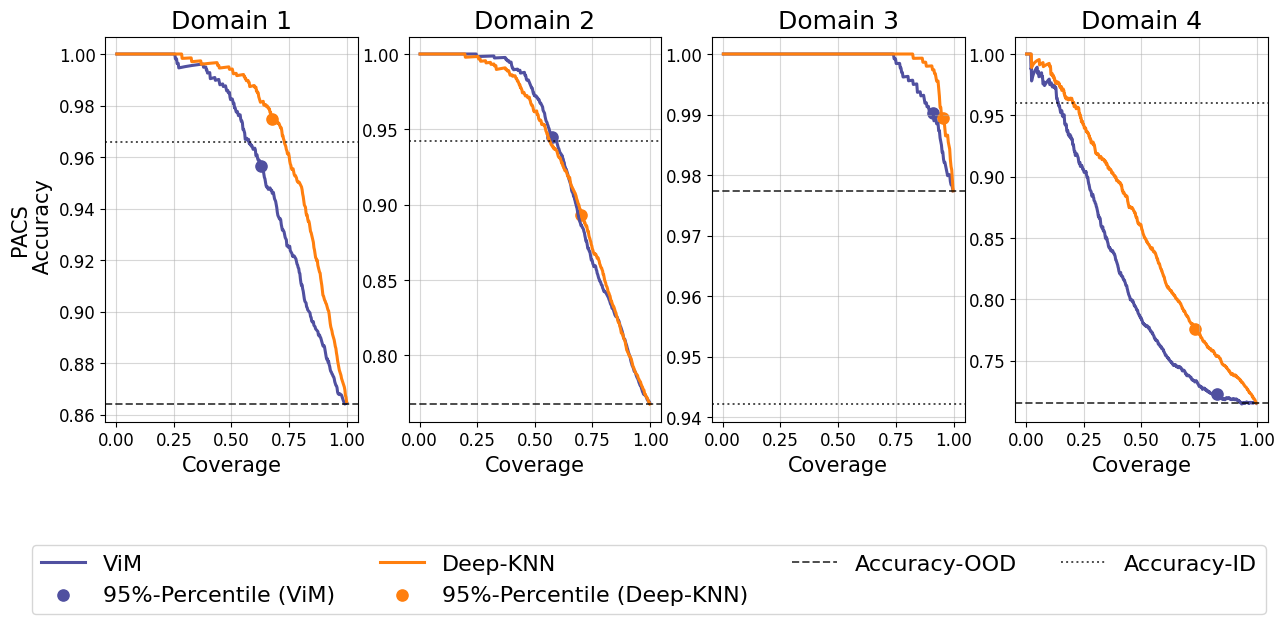

In [6]:
# Note that we only plot the results for the ERM classifier
# In the paper, we plot the mean over several classifiers
fig, axs = plot_accuracy_coverage(scores, true_false, ['ViM', 'Deep-KNN'], ['ERM'], data_set='PACS')

# Showing Accuracy Curves

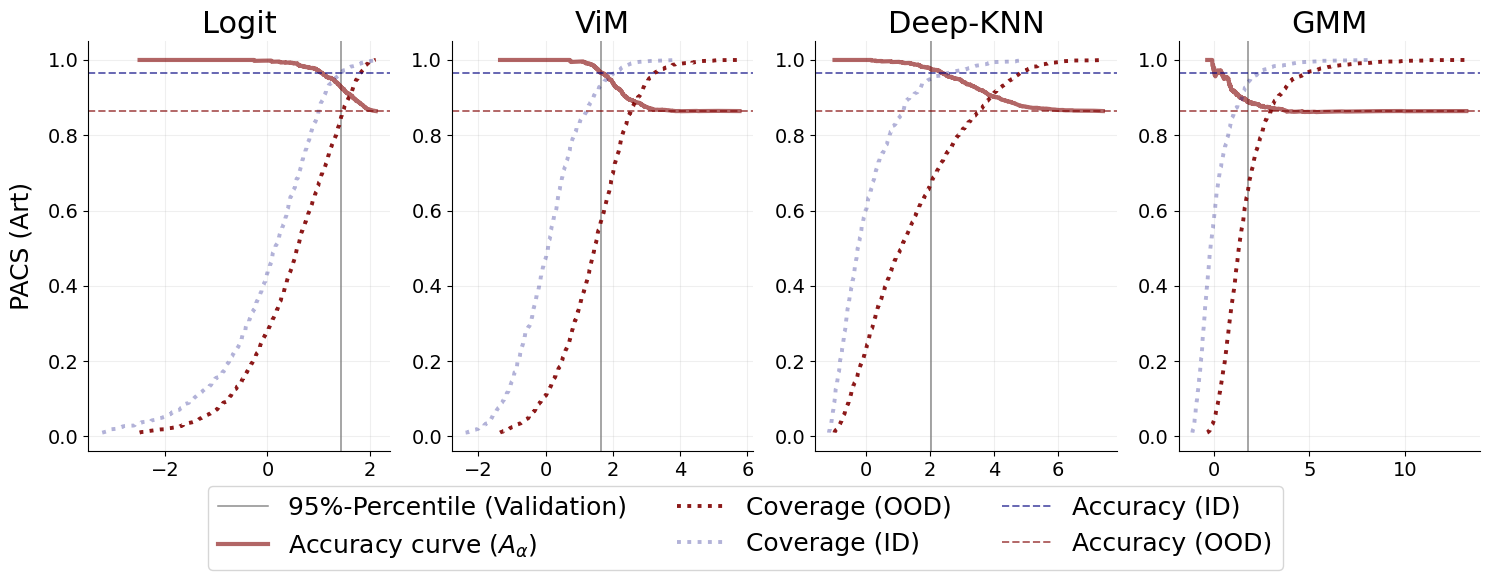

In [7]:
# Other possible domains are 0, 1, 2, 3
fig, axs = plot_accuracy_curve(scores, true_false, ['Logit', 'ViM','Deep-KNN', 'GMM'], 'PACS', 'ERM', domain=0)

# Short Introduction in How to Compute Scores

The following files are required:
* {x}_id_train.npy
* {x}_id_val.npy
* {x}_id_test.npy

where x = features, logits, labels

and the same for ood samples:
* {x}_ood
where x = features, logits, labels

Additionally we require the weights w and biases b of the last layer. 

In the following we download data for the PACS data set for one scenario (where the OOD test domain is domain 0)

In [24]:
url = 'https://drive.google.com/drive/folders/1q0OaXsU63C4VGsDoDIJcG0Eh1fDITgj4'
output = 'data/PACS/test_env_0'

# Create ouput folder if it does not exist
os.makedirs(output, exist_ok=True)

# donwload folder to directory
if  os.path.exists(output):
    gdown.download_folder(url, output=output, quiet=True, use_cookies=True)

# Data and Config Loading

In [19]:
# Here we load some standard configurations for the score functions
with open("config.yml", "r") as file:
    config = yaml.safe_load(file)

In [20]:
# Here you have to include your own path
dataset_path = "data/PACS/test_env_0/"
algorithm = 'ERM'

w = np.load(f"{dataset_path}/{algorithm}_W.npy")
b = np.load(f"{dataset_path}/{algorithm}_b.npy")

# Features/logits/labels Trainings data
features_id_train =  np.load(f"{dataset_path}/{algorithm}_features_id_train.npy")
logits_id_train = np.load(f"{dataset_path}/{algorithm}_logits_id_train.npy")
labels_id_train =  np.load(f"{dataset_path}/{algorithm}_labels_id_train.npy")
    
# Features/logits/labels Validation data
features_id_val = np.load(f"{dataset_path}/{algorithm}_features_id_val.npy")
logits_id_val = np.load(f"{dataset_path}/{algorithm}_logits_id_val.npy")
labels_id_val = np.load(f"{dataset_path}/{algorithm}_labels_id_val.npy")

# Features/logits/labels Test data
features_id_test = np.load(f"{dataset_path}/{algorithm}_features_id_test.npy")
logits_id_test = np.load(f"{dataset_path}/{algorithm}_logits_id_test.npy")
labels_id_test = np.load(f"{dataset_path}/{algorithm}_labels_id_test.npy")
print(labels_id_test.shape)

(794,)


# Score function creation

In [21]:
score_function_name = 'Softmax'

scores_id_val, score_function = create_score_function(
    features_id_train,
    logits_id_train,
    labels_id_train,
    features_id_val,
    logits_id_val,
    labels_id_val,
    w,
    b,
    score_function =  score_function_name,
    **config
)

## Compute various scores and metrics

In [25]:
# With the score function, we can compute the scores for the training and test data
scores_id_train = score_function(features_id_train, logits_id_train)
scores_id_test = score_function(features_id_test, logits_id_test)

# Here you would compute the scores for OOD data
# Therefore, we load Features/logits/labels on the OOD data
features_ood = np.load(f"{dataset_path}/{algorithm}_features_ood_test.npy")
logits_ood = np.load(f"{dataset_path}/{algorithm}_logits_ood_test.npy")
labels_ood = np.load(f"{dataset_path}/{algorithm}_labels_ood_test.npy")
scores_ood_test = score_function(features_ood, logits_ood)

# We define the metrics that we want to compute
# Here, accuracy and coverage are computed on the 95% percentile of the validation data (w.r.t. the score function)
metrics = ['quantile_95', 'accuracy']

outs = compute_metric(scores_id_val,
    scores_id_test,
    scores_ood_test,
    logits_id_val,
    labels_id_val,
    logits_id_test,
    labels_id_test,
    logits_ood_test=logits_ood,
    labels_ood_test=labels_ood,
    metrics=metrics,
)
outs['score'] = 'Softmax'

In [26]:
#n_95 is the accuracy at threshold 95%percentile of validation set
#n_95_frac is the fraction of included samples at this particular threshold
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = outs.keys()
x.add_row(outs.values())

# n_95_frac_ood is the fraction of OOD samples included at this particular threshold
# n_95_frac_id is the fraction of ID samples included at this particular threshold
# n_95_ood is the accuracy on the OOD samples in the competence region at this particular threshold
# n_95_id is the accuracy on the ID samples at this particular threshold
print(x)

+--------------------+--------------------+--------------+---------------+--------------------+--------------------+--------------------+---------+
|    acc_id_test     |     acc_id_val     | acc_ood_test | n_95_frac_ood |      n_95_ood      | n_95_frac_id_test  |    n_95_id_test    |  score  |
+--------------------+--------------------+--------------+---------------+--------------------+--------------------+--------------------+---------+
| 0.9659949622166247 | 0.9508816120906801 | 0.8642578125 |  0.861328125  | 0.9297052025794983 | 0.9508816120906801 | 0.9894039630889893 | Softmax |
+--------------------+--------------------+--------------+---------------+--------------------+--------------------+--------------------+---------+
